In [1]:
import numpy as np
import pandas as pd

In [2]:
ltc = pd.read_csv('../data/bc_ltc_final.csv')
odhf = pd.read_excel('../data/odhf_ltc.xlsx')

In [3]:
ltc['facility_name'] = ltc['FACILITY_NAME'].str.lower()

In [4]:
merge = pd.merge(ltc, odhf, on = 'facility_name', how = 'left')

In [5]:
merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 296
Data columns (total 91 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FACILITY_NAME              297 non-null    object 
 1   Number of dead             297 non-null    float64
 2   HCC_CODE                   297 non-null    object 
 3   HLTH_AUTH                  297 non-null    object 
 4   STREET_ADDRESS             297 non-null    object 
 5   CITY                       297 non-null    object 
 6   POSTAL                     297 non-null    object 
 7   PHONE                      297 non-null    object 
 8   OPEN_DATE                  288 non-null    object 
 9   COUNCIL                    290 non-null    object 
 10  ACCRED_STATUS              297 non-null    object 
 11  BEDS_PRIVATE               297 non-null    int64  
 12  BEDS_PUBLIC                297 non-null    int64  
 13  BEDS_TOTAL                 297 non-null    int64  

#### Fill lat/lon NAs with BC Gov Data -- <mark> SAME LTCS ARE MISSING VALUES </mark>

In [6]:
# bcgov = pd.read_csv('../data/gsr_residential_care.csv')
# bcgov_ltc = bcgov.loc[bcgov.LONG_TERM_CARE == 'Y']

# dr_cols = ['TYPE', 'STREET_ADDRESS', 'CITY', 'INSPECTION_URL',
#           'GOVERNING_REGULATION', 'HEALTH_AUTHORITY', 'MENTAL_HEALTH',
#        'MENTAL_HEALTH_MAX_CAP', 'HOSPICE', 'HOSPICE_MAX_CAP', 'SUBSTANCE_USE',
#        'SUBSTANCE_USE_MAX_CAP', 'LONG_TERM_CARE', 'LONG_TERM_CARE_MAX_CAP',
#        'COMMUNITY_LIVING', 'COMMUNITY_LIVING_MAX_CAP', 'ACQUIRED_BRAIN_INJURY',
#        'ACQUIRED_BRAIN_INJURY_MAX_CAP']
# bcgov_ltc.drop(columns = dr_cols, inplace = True)



In [7]:
# # merge on postal code
# def rm_space(x):
#     return x.replace(' ','')

# bcgov_ltc['POSTAL'] = bcgov_ltc.POSTAL_CODE.map(rm_space)

# complete = pd.merge(merge, bcgov_ltc, on = 'POSTAL', how = 'outer')

# complete.info()

In [8]:
# complete.latitude.fillna(complete['LATITUDE'], inplace = True)
# complete.longitude.fillna(complete['LONGITUDE'], inplace = True)

## **Geocode leftover nulls**

In [9]:
from geopy import *
import geopandas

In [10]:
locator = Nominatim(user_agent="myGeocoder")

In [11]:
# reformat address to be one string
address = []
for s,c in zip(merge['STREET_ADDRESS'].to_list(), merge['CITY'].to_list()):
        address.append("{}, {}, British Columbia, Canada".format(s,c))
        
merge['address'] = address
merge.address

0       5451-204th St, Langley, British Columbia, Canada
1      1070 Lynn Valley Rd, North, North Vancouver, B...
2      7801 Argyle St., Vancouver, British Columbia, ...
3      1233 Haro Street, Vancouver, British Columbia,...
4      7850 Champlain Cresc, Vancouver, British Colum...
                             ...                        
292    2510 West Hwy 62, Hazelton, British Columbia, ...
293    1099 Cambie Street, Vancouver, British Columbi...
294    4950 Heather Street, Vancouver, British Columb...
295    555 - 2nd Avenue, Campbell River, British Colu...
296      5939-180th St, Surrey, British Columbia, Canada
Name: address, Length: 297, dtype: object

<mark>**CAUTION:** Slow script below </mark>

In [12]:
from geopy.extra.rate_limiter import RateLimiter

# 1 - convenient function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# 2- - create location column
merge['location'] = merge['address'].apply(geocode)

# 3 - create longitude, laatitude and altitude from location column (returns tuple)
merge['point'] = merge['location'].apply(lambda loc: tuple(loc.point) if loc else None)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('1070 Lynn Valley Rd, North, North Vancouver, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1320, in do_open
    r = h.getresponse()
  File "//anaconda3/lib/python3.7/http/client.py", line 1336, in getresponse
    response.begin()
  File "//anacond

RateLimiter caught an error, retrying (0/2 tries). Called with (*('2920 Laburnum Dr, Trail, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 966, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1406, in connect
    super().connect()
  File

RateLimiter caught an error, retrying (0/2 tries). Called with (*('704 West 69th Avenue, Vancouver, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 966, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1414, in connect
    server_hostname=

RateLimiter caught an error, retrying (0/2 tries). Called with (*('8838 Glover Road, Langley, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 966, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1414, in connect
    server_hostname=server

RateLimiter caught an error, retrying (0/2 tries). Called with (*('133 Blain Road, Salt Spring Island, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 966, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1414, in connect
    server_hostna

RateLimiter caught an error, retrying (0/2 tries). Called with (*('100 Eleventh Street, Nanaimo, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 966, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1414, in connect
    server_hostname=ser

RateLimiter caught an error, retrying (0/2 tries). Called with (*('5800 Mountain View Boulevard, Delta, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 966, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1406, in connect
    super().conn

RateLimiter caught an error, retrying (0/2 tries). Called with (*('55 Cokato Road, Fernie, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1320, in do_open
    r = h.getresponse()
  File "//anaconda3/lib/python3.7/http/client.py", line 1336, in getresponse
    response.begin()
  File "//anaconda3/lib/python3.7/http

RateLimiter caught an error, retrying (0/2 tries). Called with (*('709 10th Street, Castlegar, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "//anaconda3/lib/python3.7/http/client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "//anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "//anaconda3/lib/python3.7/http/client.py", line 966, in send
    self.connect()
  File "//anaconda3/lib/python3.7/http/client.py", line 1414, in connect
    server_hostname=serve

RateLimiter caught an error, retrying (0/2 tries). Called with (*('800 Centre St., Burns Lake, British Columbia, Canada',), **{}).
Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1360, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "//anaconda3/lib/python3.7/urllib/request.py", line 1320, in do_open
    r = h.getresponse()
  File "//anaconda3/lib/python3.7/http/client.py", line 1336, in getresponse
    response.begin()
  File "//anaconda3/lib/python3.7/

In [13]:
# 4 - split point column into latitude, longitude and altitude columns
# merge[['latitude', 'longitude', 'altitude']] = pd.DataFrame(merge['point'].tolist(), index=merge.index)

def pt_to_x(pt):
#     print(pt)
    try:
        latitude, longitude, altitude = pt
        return latitude
    except TypeError:
#         print("can't unpack {}".format(type(pt)))
        return pt

def pt_to_y(pt):
    try:
        latitude, longitude, altitude = pt
        return longitude
    except TypeError:
        return pt
    



In [14]:
merge['geo_lat'] = merge['point'].map(pt_to_x)
merge['geo_lon'] = merge['point'].map(pt_to_y)

**Lat/Lon Assesment:**


In [15]:
ind_rpl = merge[merge['geo_lat'].notnull() & merge['latitude'].isnull()].index
print("Number of lats that will be replaced by geocoding:", len(ind_rpl), "\n",
     "Total number of null lats:", len(merge[merge['latitude'].isnull()].index))

Number of lats that will be replaced by geocoding: 122 
 Total number of null lats: 139


In [16]:
merge.latitude.fillna(merge['geo_lat'], inplace = True)
merge.longitude.fillna(merge['geo_lon'], inplace = True)

In [17]:
print("coordinates not filled by geocoder:", len(merge[merge.latitude.isnull()]))

coordinates not filled by geocoder: 17


In [18]:
merge.iloc[ind_rpl].to_csv('../data/replaced_LATS.csv')

**Export**

In [19]:
merge.columns

Index(['FACILITY_NAME', 'Number of dead', 'HCC_CODE', 'HLTH_AUTH',
       'STREET_ADDRESS', 'CITY', 'POSTAL', 'PHONE', 'OPEN_DATE', 'COUNCIL',
       'ACCRED_STATUS', 'BEDS_PRIVATE', 'BEDS_PUBLIC', 'BEDS_TOTAL',
       'ROOMS_PRIVATE', 'ROOMS_SEMI', 'ROOMS_MULTI', 'COMPLAINTS',
       'SUB_COMPLAINTS', 'INCIDENT_OUTBREAK', 'INCIDENT_ABUSE',
       'INCIDENT_FALL', 'INCIDENT_POISON', 'INCIDENT_MEDICATION',
       'INCIDENT_WANDERING', 'INCIDENT_INJURY', 'INCIDENT_AGGRESSION',
       'INCIDENT_OUTBREAK_100', 'INCIDENT_ABUSE_100', 'INCIDENT_FALL_100',
       'INCIDENT_POISON_100', 'INCIDENT_MEDICATION_100',
       'INCIDENT_WANDERING_100', 'INCIDENT_INJURY_100',
       'INCIDENT_AGGRESSION_100', 'AGE', 'FEMALE', 'AGE_85_PLUS',
       'AGE_UNDER_65', 'STAY_LENGTH', 'DEPRESSION', 'ADL_DEPENDENT',
       'CPS_SEVERE', 'DEMENTIA', 'ABS_PHYS_ABUSIVE', 'ISE', 'ISE_LOW', 'CMI',
       'THERAPY_PT', 'THERAPY_RT', 'THERAPY_OT', 'MEDS_DEPRESSION',
       'MEDS_ANTIPSYCHOTICS', 'RESTRAINTS', 'INSPEC

In [25]:
merge.drop(columns = ['index', 'source_facility_type', 'odhf_facility_type', 'provider',
       'unit', 'street_no', 'street_name', 'postal_code', 'city', 'province',
       'source_format_str_address', 'CSDname', 'CSDuid', 'Pruid','address', 'location', 'point', 'geo_lat', 'geo_lon'
                     ], inplace = True)

In [26]:
merge.to_csv('../data/bc-ltc-FINAL.csv')

# MAP

In [27]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [30]:
street_map = gpd.read_file('../data/HA/bc-health-authorities.geojson')

# with gov lat/lon data
geometry = [Point(xy) for xy in zip(merge.latitude, merge.longitude)]
crs = {'init' : 'EPSG:4326'} # coordinate ref system


geo_df = gpd.GeoDataFrame(merge,
                         crs = crs,
                         geometry = geometry)

geo_df[['outbreak_status','POSTAL', 'latitude', 'longitude', 'geometry']].head()



,outbreak_status,POSTAL,latitude,longitude,geometry
0,yes,V3A5M9,49.101567,-122.657303,POINT (49.102 -122.657)
1,yes,V7J1Z8,49.333960,-123.045000,POINT (49.334 -123.045)
2,yes,V5P3L6,49.213284,-123.073098,POINT (49.213 -123.073)
3,yes,V6E3Y5,49.285771,-123.129000,POINT (49.286 -123.129)
4,yes,V5S4C7,49.213533,-123.028804,POINT (49.214 -123.029)


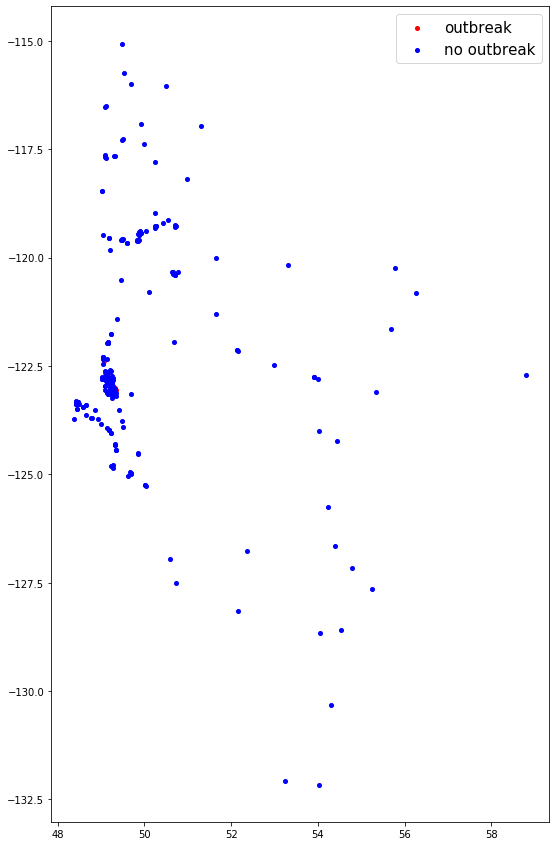

In [32]:
fig,ax = plt.subplots(figsize = (15,15))
# street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
            
geo_df[geo_df['outbreak_status'] == 'yes'].plot(ax = ax, markersize = 16,
                                               color = 'red', marker = 'o',
                                               label = "outbreak")
geo_df[geo_df['outbreak_status'] == 'no'].plot(ax = ax, markersize = 16,
                                               color = 'blue', marker = 'o',
                                               label = "no outbreak")
plt.legend(prop={'size' : 15})